Number of Omega-automaton states (including the trap state): 12
Number of accepting pairs: 8


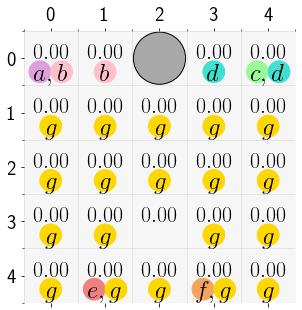

In [14]:
%matplotlib inline
from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
import pickle

# Specification
ltl = '(GFa & FGb) | (GFc & FGd) | (GFe & GFf & FGg)'
oa = OmegaAutomaton(ltl,oa_type='dpa')
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])
print('Number of accepting pairs:',oa.shape[0])
display(oa)

# MDP Description
shape = (5,5)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
    ['E',  'E',  'B',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E'],
    ['E',  'E',  'E',  'E',  'E']
])

label = np.array([
    [('a','b'), ('b',),    (),     ('d',),    ('c','d')],
    [('g',),    ('g',),    ('g',), ('g',),    ('g',)],
    [('g',),    ('g',),    ('g',), ('g',),    ('g',)],
    [('g',),    ('g',),    (),     ('g',),    ('g',)],
    [('g',),    ('e','g'), ('g',), ('f','g'), ('g',)]
],dtype=np.object)

reward = np.zeros(shape)

lcmap={
    'a':'plum',
    'b':'pink',
    'c':'palegreen',
    'd':'turquoise',
    'e':'lightcoral',
    'f':'sandybrown',
    'g':'gold',
}

grid_mdp = GridMDP(shape=shape,structure=structure,reward=reward,label=label,figsize=5,robust=True,lcmap=lcmap)  # Use figsize=4 for smaller figures
grid_mdp.plot()
# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)

# Q=csrl.minimax_q(T=2**10,K=2**10,start=(3,2))
# Q=csrl.shapley(T=2**10)
Q = np.load('Q.npy')
with open('csrl.pkl','rb') as f:
    csrl = pickle.load(f)

In [3]:
# Calculate the policy
policy = np.argmax(np.min(Q,axis=-1),axis=-1)
policy_ = np.take_along_axis(np.argmin(Q,axis=-1),np.expand_dims(policy,axis=-1),axis=-1).reshape(policy.shape)

value = np.max(np.min(Q,axis=-1),axis=-1)
# _value = np.copy(value)
# _policy = np.copy(policy)
# _value[:] = np.max(value,axis=0)
# _policy[:] = np.argmax(value,axis=0)

# ind = (csrl.discountC*_value) > value
# policy[ind] = _policy[ind] + len(csrl.mdp.A)
csrl.plot(value=value,policy=policy,policy_=policy_)

interactive(children=(IntSlider(value=0, description='i', max=3), IntSlider(value=0, description='q', max=5), …

In [19]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from ipywidgets.widgets import IntSlider
from ipywidgets import interact
# Q=csrl.shapley(T=2**10)
Q = np.load('path_Q.npy')
with open('path_csrl.pkl','rb') as f:
    csrl = pickle.load(f)
policy = np.argmax(np.min(Q,axis=-1),axis=-1)
policy_ = np.take_along_axis(np.argmin(Q,axis=-1),np.expand_dims(policy,axis=-1),axis=-1).reshape(policy.shape)
value = np.max(np.min(Q,axis=-1),axis=-1)
episode=csrl.simulate(policy,policy_,value=value,start=(3,2),T=1000)

interactive(children=(IntSlider(value=0, description='t', max=999), Output()), _dom_classes=('widget-interact'…

In [23]:
import matplotlib.pyplot as plt
from ipywidgets.widgets import IntSlider
from ipywidgets import interact
    
self = csrl
T=1000
start=(0,0)
e = 1-self.discount
e_ = np.sqrt(e)

state = (0,self.oa.q0)+(start if start else self.mdp.random_state())
episode = [state]
for t in range(T):
    a1 = policy[state]
    a2 = policy_[state]

    states, probs = self.transition_probs[state][a1][a2]
    next_state = states[np.random.choice(len(states),p=probs)]

    state = (0,)+next_state[1:]

    episode.append(state)


def plot_agent(t):
    val = value[episode[t][:2]] if value is not None else None
    self.mdp.plot(value=val,policy=policy[episode[t][:2]],policy_=policy_[episode[t][:2]],agent=episode[t][2:])
t=IntSlider(value=0,min=0,max=T-1)
interact(plot_agent,t=t)


interactive(children=(IntSlider(value=0, description='t', max=999), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_agent(t)>

In [26]:
episode[-1]
Q[0, 4, 4, 0]

array([[0.77088865, 0.76439543, 0.75712535, 0.77166552],
       [0.7675029 , 0.77477299, 0.76023281, 0.77477299],
       [0.71583543, 0.7166123 , 0.70207212, 0.71622386],
       [0.77399612, 0.77477299, 0.77438455, 0.77477299]])

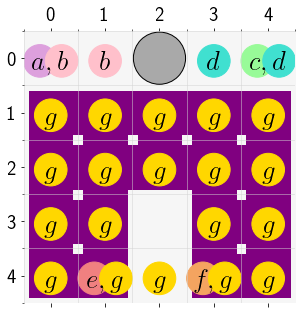

In [31]:
policy=np.argmax(Q,axis=4)

hidden = list(zip(*np.where(csrl.mdp.structure == 'E')))

path = {
    (1,0) : 'dr',
    (2,0) : 'udr',
    (3,0) : 'udr',
    (4,0) : 'ur',
    (1,1) : 'ldr',
    (2,1) : 'ludr',
    (3,1) : 'lud',
    (4,1) : 'lu',
    (1,2) : 'ldr',
    (2,2) : 'lur',
    (1,3) : 'ldr',
    (2,3) : 'ludr',
    (3,3) : 'udr',
    (4,3) : 'ur',
    (1,4) : 'ld',
    (2,4) : 'lud',
    (3,4) : 'lud',
    (4,4) : 'lu'
}
csrl.plot(np.zeros(value.shape),policy=policy,policy_=policy_,iq=(1,3),path=path,hidden=hidden,save='robust_path_dpa.pdf')

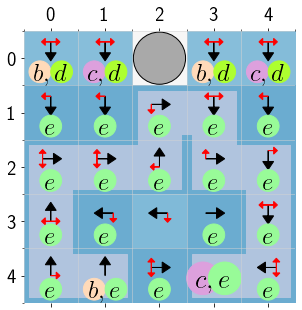

In [5]:
path = {
    (4,1) : 'l',
    (4,0) : 'ru',
    (3,0) : 'du',
    (2,0) : 'dr',
    (2,1) : 'lr',
    (2,2) : 'lu',
    (1,2) : 'dr',
    (1,3) : 'ld',
    (2,3) : 'ur',
    (2,4) : 'ld',
    (3,4) : 'ud',
    (4,4) : 'ul',
    (4,3) : 'r'
}
hidden=[(4,3)]
csrl.plot(value=value,policy=policy,policy_=policy_,iq=(1,2),path=path,hidden=hidden,save='robust_controller_b_to_c.pdf')

In [30]:
csrl.oa.shape

(8, 12)

In [3]:
import numpy as np
import pickle
# Q=csrl.shapley(T=2**10)
Q = np.load('Q.npy')
with open('csrl.pkl','rb') as f:
    csrl = pickle.load(f)
policy = np.argmax(np.min(Q,axis=-1),axis=-1)
policy_ = np.take_along_axis(np.argmin(Q,axis=-1),np.expand_dims(policy,axis=-1),axis=-1).reshape(policy.shape)
value = np.max(np.min(Q,axis=-1),axis=-1)
episode=csrl.simulate(policy,policy_,value=value,start=(3,2),T=1000)
# episode

interactive(children=(IntSlider(value=0, description='t', max=999), Output()), _dom_classes=('widget-interact'…

In [11]:
# np.save('robust_episode',np.array(episode))
import os
import matplotlib.pyplot as plt
pad=5
animation='robust'
T=100
if not os.path.exists(animation):
    os.makedirs(animation)
for t in range(T):
    csrl.mdp.plot(value=value[episode[t][:2]],policy=policy[episode[t][:2]],policy_=policy_[episode[t][:2]],agent=episode[t][2:],save=animation+os.sep+str(t).zfill(pad)+'.png',title='Time: '+str(t)+',  Accepting Pair: '+str(episode[t][0]+1)+',  DRA State (Mode): '+str(episode[t][1]))
    plt.close()
os.system('ffmpeg -r 3 -i '+animation+os.sep+'%0'+str(pad)+'d.png -vcodec libx264 -y '+animation+'.mp4')

0